In [ ]:
#| default_exp models.tsmixer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# TSMixer 

Time-Series Mixer (TSMixer) is a novel architecture specifically designed for multivariate forecasting. It is built by stacking multiple multi-layer perceptrons (MLPs) and it applies mixing operations along both the time and feature dimensions to extract information.

This method achieved state-of-the-art results on many popular datasets, like `Electricity Transformer (Etth)`, `Weather` and `Traffic`.

**References**<br>
-[Si-An Chen, Chun-Liang Li, Nathanel C. Yoder, Sercan Ö. Arik, Tomas Pfister (2023). TSMixer: An All-MLP Architecture for Time Series Forecasting.](https://arxiv.org/pdf/2303.06053.pdf)

![Figure 1. TSMixer.](imgs_models/tsmixer.png)

In [ ]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate

In [ ]:
#| hide
# Testing a single class for time and feature mixing
class ResBlock(nn.Module):
    def __init__(self, n_series, norm_type, dropout, ff_dim):
        super(ResBlock, self).__init__()

        # Temporal Linear
        self.temporal_linear = nn.Sequential(
            nn.BatchNorm2d(n_series),
            torch.transpose, # [Batch, Channel, Input Length]
            nn.Linear(n_series, n_series),
            nn.ReLU(),
            inputs.permute(0, 2, 1), # [Batch, Input Length, Channel]
            nn.Dropout(dropout)
        )

        # Feature Linear
        self.feature_linear = nn.Sequential(
            nn.BatchNorm2d(n_series),
            nn.Linear(n_series, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, n_series),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.temporal_linear(inputs)
        res = x + inputs

        x = self.feature_linear(res)

        return x + res

In [ ]:
#| export

class BatchNormalization(nn.Module):
    def __init__(self):
        super(BatchNormalization, self).__init__()

        self.batch_norm = nn.BatchNorm2d(num_features=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        output = self.batch_norm(x)
        output = output.squeeze(1)

        return output

In [ ]:
#| export

class TimeMixingBlock(nn.Module):
    def __init__(self, input_size, dropout):
        super(TimeMixingBlock, self).__init__()

        # self.norm = BatchNormalization()
        self.linear = nn.Linear(input_size, input_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        # y = self.norm(x)
        y = torch.permute(x, (0, 2, 1))
        y = self.linear(y)
        y = self.activation(y)
        y = torch.permute(y, (0, 2, 1))
        y = self.dropout(y)

        return x + y

In [ ]:
#| export

class FeatureMixingBlock(nn.Module):
    def __init__(self, input_size, dropout, ff_dim):
        super(FeatureMixingBlock, self).__init__()

        # self.norm = BatchNormalization()
        self.linear1 = nn.Linear(input_size, ff_dim)
        self.linear2 = nn.Linear(ff_dim, input_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        # y = self.norm(x)
        y = torch.permute(x, (0, 2, 1))
        y = self.linear1(y)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.linear2(y)
        y = self.dropout(y)
        y = torch.permute(y, (0, 2, 1))

        return x + y

In [ ]:
#| export
class TSMixer(BaseMultivariate):
    """ TSMixer

        Time-Series Mixer (TSMixer) is a novel architecture specifically designed for 
        multivariate forecasting. It is built by stacking multiple multi-layer 
        perceptrons (MLPs) and it applies mixing operations along both the time and 
        feature dimensions to extract information.

        **Parameters:**<br>
        `h`: int, Forecast horizon. <br>
        `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
        `n_series`: int, number of time-series.<br>
        `dropout_rate`: float, rate of dropout in the MLP<br>
        `n_blocks`: int, number of mixing blocks<br>
        `ff_dim`: int, dimensions of the feedforward layer for the feature mixing block<br>
        `stat_exog_list`: str list, static exogenous columns.<br>
        `hist_exog_list`: str list, historic exogenous columns.<br>
        `futr_exog_list`: str list, future exogenous columns.<br>
        `n_stacks`: int=2, number of stacks in the model.<br>
        `multi_layer`: int=5, multiplier for FC hidden size on StemGNN blocks.<br>
        `dropout_rate`: float=0.5, dropout rate.<br>
        `leaky_rate`: float=0.2, alpha for LeakyReLU layer on Latent Correlation layer.<br>
        `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
        `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
        `max_steps`: int=1000, maximum number of training steps.<br>
        `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
        `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
        `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
        `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
        `batch_size`: int, number of windows in each batch.<br>
        `step_size`: int=1, step size between each window of temporal data.<br>
        `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
        `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
        `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
        `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
        `alias`: str, optional,  Custom name of the model.<br>
        `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
    
    """
    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    
    def __init__(self,
                h,
                input_size,
                n_series,
                dropout_rate=0.7,
                n_blocks=2,
                ff_dim=64,
                loss=MAE(),
                valid_loss=None,
                learning_rate=1e-3,
                max_steps=1000,
                val_check_steps=100,
                batch_size=32,
                step_size=1,
                num_lr_decays=0,
                early_stop_patience_steps=-1,
                scaler_type="robust",
                futr_exog_list=None,
                hist_exog_list=None,
                stat_exog_list=None,
                num_workers_loader=0,
                drop_last_loader=False,
                random_seed=1,
                alias=None,
                **trainer_kwargs,):
        
        super(TSMixer, self).__init__(h=h,
                                      input_size=input_size,
                                      n_series=n_series,
                                      loss=loss,
                                      valid_loss=valid_loss,
                                      learning_rate=learning_rate,
                                      max_steps=max_steps,
                                      val_check_steps=val_check_steps,
                                      batch_size=batch_size,
                                      step_size=step_size,
                                      num_lr_decays=num_lr_decays,
                                      early_stop_patience_steps=early_stop_patience_steps,
                                      scaler_type=scaler_type,
                                      futr_exog_list=futr_exog_list,
                                      hist_exog_list=hist_exog_list,
                                      stat_exog_list=stat_exog_list,
                                      num_workers_loader=num_workers_loader,
                                      drop_last_loader=drop_last_loader,
                                      random_seed=random_seed,
                                      alias=alias,
                                      **trainer_kwargs,)
       
        self.dropout_rate = dropout_rate
        self.n_blocks = n_blocks
        self.ff_dim = ff_dim
        
        # Architecture
        self.time_mixing = TimeMixingBlock(input_size, self.dropout_rate)
        self.feature_mixing = FeatureMixingBlock(input_size, self.dropout_rate, self.ff_dim)
        self.linear = nn.Linear(input_size, h)

    def forward(self, windows_batch):
        # Parse batch
        insample_y    = windows_batch['insample_y']

        y = insample_y.clone()
        for _ in range(self.n_blocks):
            y = self.time_mixing(y)
            y = self.feature_mixing(y)
        y = torch.permute(y, (0, 2, 1))
        y = self.linear(y)
        y = torch.permute(y, (0, 2, 1))
        
        # y_pred = y.reshape(self.batch_size, self.h, self.loss.outputsize_multiplier)
        y_pred = self.loss.domain_map(y)
    
        return y_pred

In [ ]:
#| hide
from nbdev.showdoc import show_doc

show_doc(TSMixer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tsmixer.py#L73){target="_blank" style="float:right; font-size:smaller"}

### TSMixer

>      TSMixer (h, input_size, n_series, dropout_rate=0.7, n_blocks=2,
>               ff_dim=64, loss=MAE(), valid_loss=None, learning_rate=0.001,
>               max_steps=1000, val_check_steps=100, batch_size=32, step_size=1,
>               num_lr_decays=0, early_stop_patience_steps=-1,
>               scaler_type='robust', futr_exog_list=None, hist_exog_list=None,
>               stat_exog_list=None, num_workers_loader=0,
>               drop_last_loader=False, random_seed=1, alias=None,
>               **trainer_kwargs)

TSMixer

Time-Series Mixer (TSMixer) is a novel architecture specifically designed for 
multivariate forecasting. It is built by stacking multiple multi-layer 
perceptrons (MLPs) and it applies mixing operations along both the time and 
feature dimensions to extract information.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`n_series`: int, number of time-series.<br>
`dropout_rate`: float, rate of dropout in the MLP<br>
`n_blocks`: int, number of mixing blocks<br>
`ff_dim`: int, dimensions of the feedforward layer for the feature mixing block<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`n_stacks`: int=2, number of stacks in the model.<br>
`multi_layer`: int=5, multiplier for FC hidden size on StemGNN blocks.<br>
`dropout_rate`: float=0.5, dropout rate.<br>
`leaky_rate`: float=0.2, alpha for LeakyReLU layer on Latent Correlation layer.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int, number of windows in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

In [ ]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

In [ ]:
#| hide
# test performance fit/predict method
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MAE

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = TSMixer(h=12,
                input_size=24,
                n_series=2,
                stat_exog_list=['airline1'],
                futr_exog_list=['trend'],
                scaler_type='robust',
                max_steps=30,
                early_stop_patience_steps=3,
                val_check_steps=10,
                learning_rate=1e-3,
                loss=MAE(),
                valid_loss=None,
                batch_size=32
                )

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

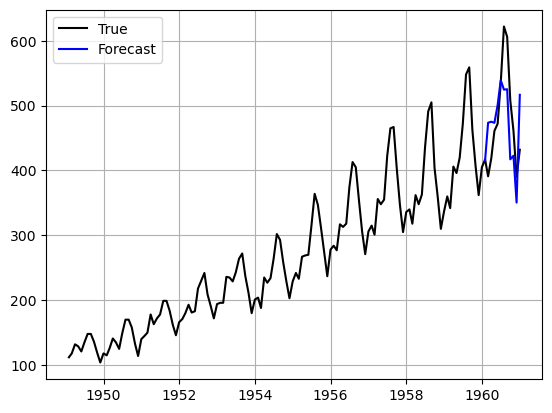

In [ ]:
#| hide
# Plot predictions

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TSMixer'], c='blue', label='Forecast')
plt.legend()
plt.grid()